<a href="https://colab.research.google.com/github/mayhd3/NSF-REU-2021/blob/main/AMIvisualizations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [105]:
import os
import pandas as pd

if not os.path.exists('SM-30.csv'):
  !gdown --id 1UnP8x_WQ-Aroq8Rz4C1NUSEG9Iul1y7r

sm30 = pd.read_csv('SM-30.csv', header=None, index_col=1)
print(sm30)

           0          2           3   ...          48          49          50
1                                     ...                                    
20160101    1     Friday   12.321833  ...   51.175717  143.252283  137.462967
20160102    1   Saturday   50.280717  ...   69.247467   34.006950   13.018783
20160103    1     Sunday   18.515583  ...   87.413983   34.309583    8.045783
20160104    1     Monday   13.393400  ...   57.762917   59.193917   84.350667
20160105    1    Tuesday   87.745500  ...   99.809000   37.494800   62.593817
...       ...        ...         ...  ...         ...         ...         ...
20161210  114   Saturday   70.341083  ...  103.174867  105.520250   99.261717
20161211  114     Sunday  107.108983  ...   78.534017   55.942400   61.001317
20161212  114     Monday   69.485367  ...   94.071350   39.962617   71.267533
20161213  114    Tuesday   58.695450  ...  114.110617   71.144167   66.459417
20161214  114  Wednesday   67.376800  ...   80.857933   60.40181

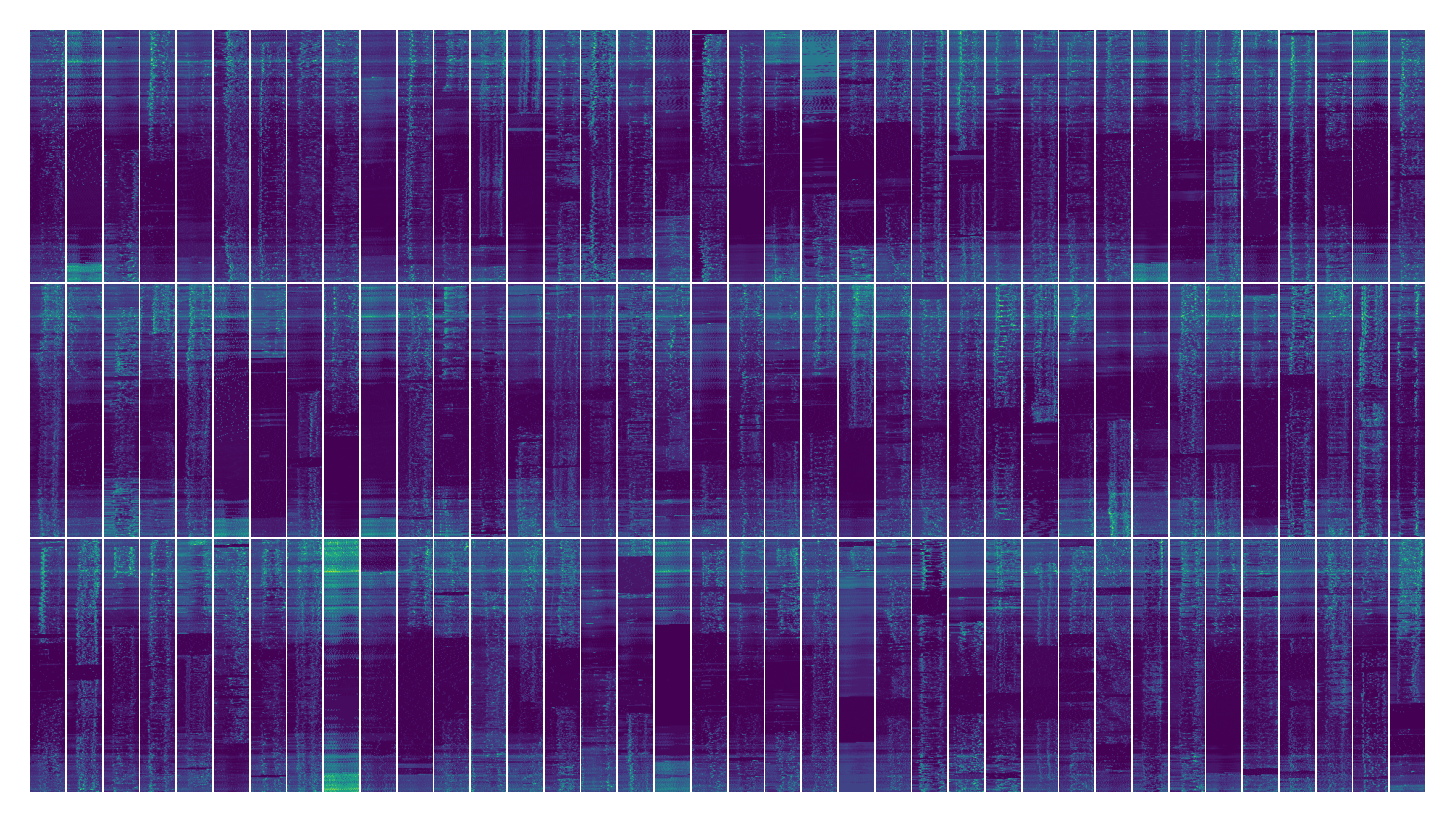

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

meters = np.split(
    sm30.iloc[:,2:].to_numpy(),
    sm30[0].diff()[1:].to_numpy().nonzero()[0] + 1
)

def heatmap(data):
  ig = ImageGrid(plt.gcf(), 111, nrows_ncols=(3, 38), axes_pad=2/300, direction='column')

  for ax,im in zip(ig,data):
    ax.set_axis_off()
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    ax.imshow(im)

plt.figure(dpi=300)
heatmap(meters)

In [107]:
import ipywidgets as ipw
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.colors as mcolors
import random as rng

out2 = ipw.Output()

def acf(index):
  colors = list(mcolors.TABLEAU_COLORS.values())

  if 0 <= index < len(meters):
    flat = meters[index].flatten()

    with out2:
      color = colors[index%len(colors)]
      out2.clear_output(wait=True)

      plt.figure(dpi=100)
      plt.title("Meter " + str(index))
      plt.plot(flat, c=color)

      plt.figure(dpi=100)
      plot_acf(flat, ax=plt.gca(), lags=np.arange(len(flat))[::500], c=color)

      plt.show()

def inttext2(event):
  acf(event['new'])

txt2 = ipw.IntText(
  value=0,
  description='Meter to plot:',
  style={'description_width': 'initial'}
)
txt2.observe(inttext2, names='value')
inttext2({'new': txt2.value})

display(txt2, out2)

IntText(value=0, description='Meter to plot:', style=DescriptionStyle(description_width='initial'))

Output()

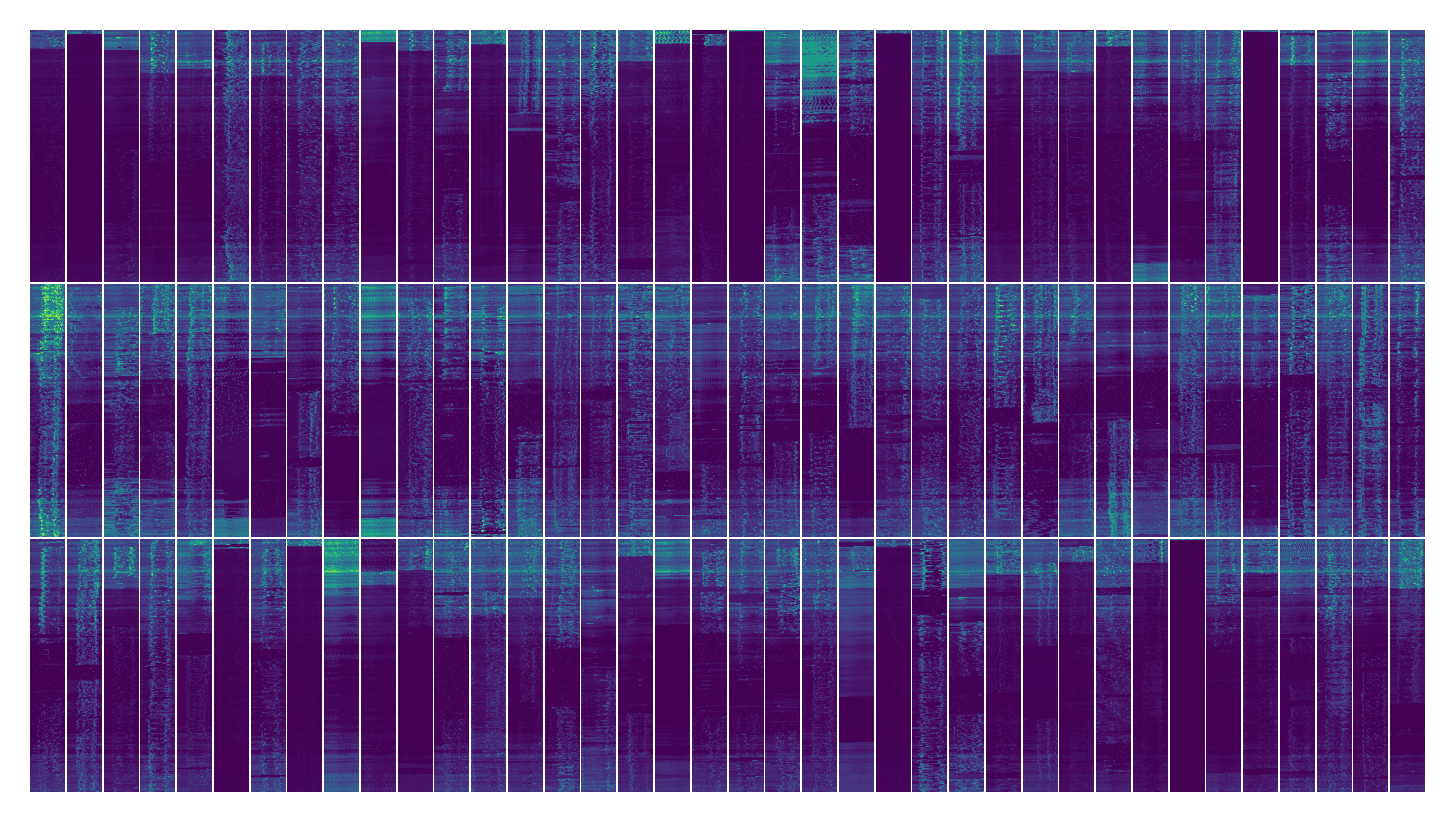

In [110]:
from copy import deepcopy

# simulate energy theft by scaling samples down, clipping them to a max, or both
fakes = deepcopy(meters)

# each sample will have a different starting date
starts = np.linspace(0,1,num=len(fakes))
np.random.shuffle(starts)

for i in range(len(fakes)):
  # theft starts at most half way through the year
  start = int(starts[i] * (len(fakes[i])-1)/2)

  # clamp max somewhere between the first and third quartile
  min, max = np.amin(fakes[i]), np.amax(fakes[i])
  lerp = starts[(i+1)%len(starts)]
  clip = (max+min)*.5 + (max-min)*.25*(lerp-.5)

  for j in range(start,len(fakes[i])):
    if (i%3) != 1:
      fakes[i][j] *= starts[i]
    if (i%3) != 0:
      fakes[i][j] = np.clip(fakes[i][j],0,clip) 

plt.figure(dpi=300)
heatmap(fakes)
